In [7]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [496]:
image = cv2.imread("coins.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = image[:, :, [2, 1, 0]]

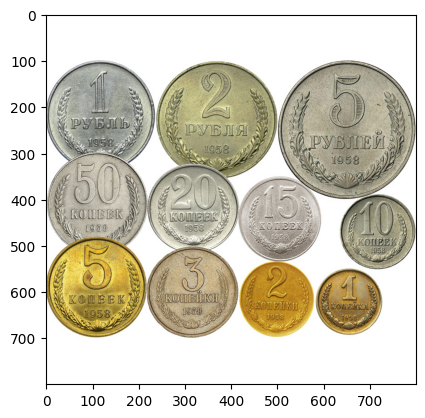

In [497]:
max_size, min_size = max(image.shape[:-1]), min(image.shape[:-1])
width, height = image.shape[:-1]

img = np.zeros((max_size, max_size, 3))
img[:,:] = image[0,0]

d2 = (max_size - min_size)//2

if width > height:
    img[:, d2:-d2] = image
else:
    img[d2:-d2, :] = image

img = img.astype(int)
plt.imshow(img)

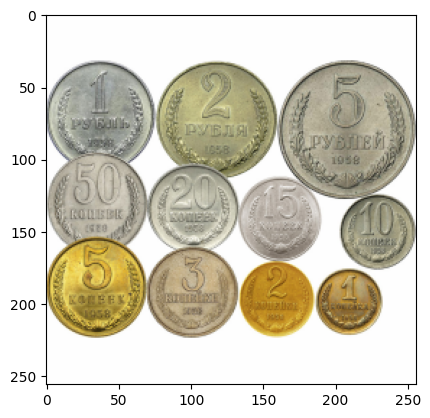

In [261]:
img_res = cv2.resize(img/255,(256,256), interpolation=cv2.INTER_AREA)
img_res = (img_res * 255).astype(int)
plt.imshow(img_res)

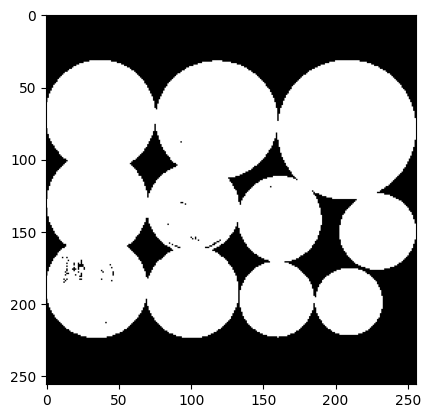

In [268]:
upper = (240,240,240)
lower = (10,10,10)
thresh = cv2.inRange(img_res, lower, upper)

plt.imshow(thresh, cmap='gray')

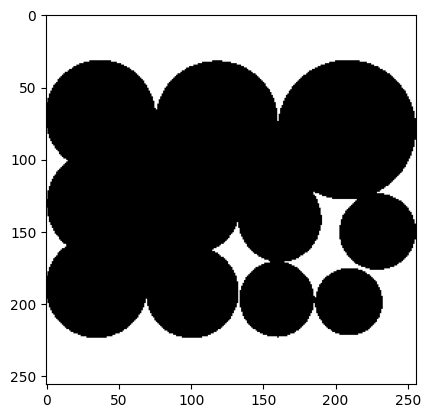

In [269]:
contours = cv2.findContours(thresh , cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

# draw white filled contours on black background
mask = np.zeros_like(img_res)
for cntr in contours:
    cv2.drawContours(mask, [cntr], 0, (255,255,255), -1)

mask = 255 - mask

plt.imshow(mask)

In [450]:
size = 75

def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h),
                           borderMode=cv2.BORDER_CONSTANT,
                           borderValue=(255,255,255))

    return rotated

def gen_random(images: list[2]):
    out_images = []

    idx = np.random.randint(10000)
    angle = np.random.random() * 360
    blur_strength = np.random.randint(1,5)
    px_crops = None

    for img in images:
        n_img = img.copy().astype(np.float64)
    
        if idx % 2 == 0:
            n_img = rotate(n_img, angle)

        # crop
        img_size = min(n_img.shape[:-1])
        px_crops = px_crops if px_crops is not None else np.random.randint(img_size - size, size=2)
        n_img = n_img[px_crops[0]:px_crops[0] + size, px_crops[1]:px_crops[1] + size]

        if idx % 5 == 0:
            n_img = cv2.blur(n_img, (blur_strength,blur_strength))
        
        
        if idx % 5 == 3:
            kernel = np.array([[-1,-1,-1], 
                            [-1, 9,-1],
                            [-1,-1,-1]])
            n_img = cv2.filter2D(n_img, -1, kernel)

        n_img = np.clip(n_img, 0, 255).astype(int)

        out_images.append(n_img)
    
    return out_images


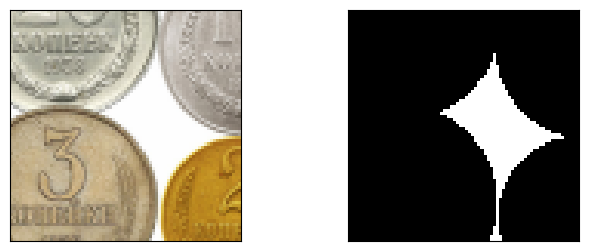

In [481]:
i, m = img_res, mask
while True:
    i, m = gen_random([img_res, mask])
    break


fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plt.imshow(i)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plt.imshow(m)

In [517]:
# save
import os

save_path = "./saved"
if not os.path.exists(save_path):
    os.makedirs(save_path)

count = 100

dataset = []

for i in range(count):
    img, msk = gen_random([img_res, mask])
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"{save_path}/{i}i.jpg", img)
    cv2.imwrite(f"{save_path}/{i}m.jpg", msk)
